# Quandela Training Seminar - Programming with Perceval

### Boson sampling

Sampling is the problem of selecting data from a large set, usually to find a smaller set of data that is representative of the entire set. Naturally, as problem sizes grow, these types of problems become intractable for classical computers. This means that even if we are able to find a solution to our problem, the time it takes us to do so will be too long, deeming the solution no longer useful to us.

In Perceval, we use photons as our bosons (indistinguishable subatomic particles with an integer spin) to perform the task of boson sampling. Boson sampling is a quantum sampling problem, drawing from a big probability distribution of output states of a system. As our knowledge of the quantum world grows and quantum hardware becomes better, we hope to offer solutions to problems previously thought intractable.

We are interested to simulate a boson sample with 6 photons and 12 modes.

In [1]:
from collections import Counter
import gzip
import pickle
import time
import random
import perceval as pcvl
from perceval.algorithm import Sampler
pcvl.__version__

'0.13.0'

#### Boson sampling with a perfect source

Let's define all the required values below.

In [2]:
n = 6       #number of photons at the input
m = 12       #number of modes
N = 50000  #number of samplings we want in the end

Now we can generate a Haar random unitary with Perceval.

In [3]:
Unitary = pcvl.Matrix.random_unitary(m) #creates a random unitary of dimension 60

To be able to decompose this unitary, first we have to choose a set of optical components we will use to do. The Mach-Zehnder interferometer (MZI) is a good choice as it is composed of only 2 beam splitters and 2 phase shifters and it is highly configurable.

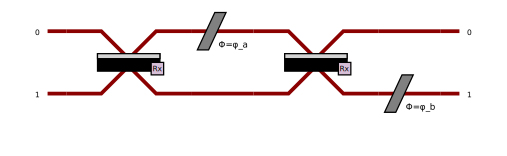

In [4]:
mzi = (pcvl.BS() // (0, pcvl.PS(phi=pcvl.Parameter("φ_a")))
       // pcvl.BS() // (1, pcvl.PS(phi=pcvl.Parameter("φ_b"))))
pcvl.pdisplay(mzi)

No we can decompose the unitary into a set of MZIs using Reck's (traingular) scheme [2].

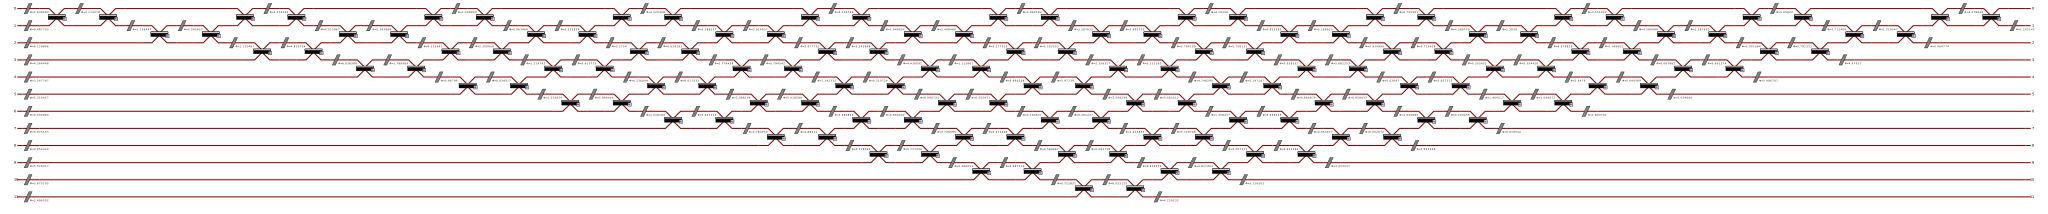

In [5]:
Linear_Circuit = pcvl.Circuit.decomposition(Unitary, mzi, phase_shifter_fn=pcvl.PS, shape="triangle")
pcvl.pdisplay(Linear_Circuit)

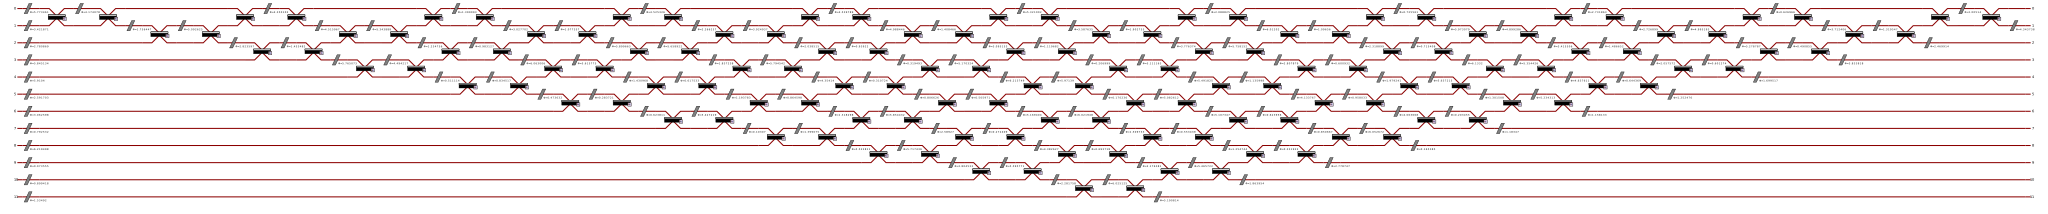

In [11]:
# You can see the circuit is shaped like a triangle, this circuit composition is called the Reck scheme.
# TO DO: Test to see how the circuit composition looks like without the variable 'shape' defined.
Linear_Circuit = pcvl.Circuit.decomposition(Unitary, mzi, phase_shifter_fn=pcvl.PS)
pcvl.pdisplay(Linear_Circuit)

#### Running simulation

Now we can choose the way to perform the simulation of boson sampling with Perceval. The number of photons is within what we could simulate with the Naive backend, however the output space is far too big just to enumerate and store the states so we chose the CliffordClifford2017 backend instead. We encourage you to check out our multiple simulation backend options and their performance comparison on different types of problems available to view on the Perceval documentation.

In [6]:
QPU = pcvl.Processor("CliffordClifford2017", Linear_Circuit)

Since this isn't a real problem and we are just trying to show the power of quantum computing when it comes to difficult problems to solve, such as boson sampling, we don't care what the input to our circuit is and can choose a random one.

In [7]:
def generate_input(n, m, modes = None):
    "This function randomly chooses an input with n photons in m modes."
    if modes == None : #the function works with a given number of modes m, otherwise selecting them randomly
        modes = sorted(random.sample(range(m),n))
    state = "|"
    for i in range(m):
        state = state + "0"*(1 - (i in modes)) +"1"*(i in modes)+ ","*(i < m-1)
    return pcvl.BasicState(state + ">")

input_state = generate_input(n, m)
print("The input state: ", input_state)
QPU.with_input(input_state) #giving the processor the input state

The input state:  |1,0,0,1,0,1,0,1,0,0,1,1>


Using this input, our output states are states composed of n photons in m modes.

In [8]:
QPU.min_detected_photons_filter(0) #we're telling the processor that we want to keep all outputs
# We're telling Perceval that we need *at least* 0 photons in our output, thus we will keep all
# possible outputs. Naturally, we cannot observe more photons in the output than there were in the
# input so we'll never be able to filter by a number higher than the number of photons in the input.

sampler = Sampler(QPU)

print("The sampled outputs are:")
for out_state in sampler.samples(10)["results"]:
    print(out_state)

The sampled outputs are:
|0,1,2,0,0,1,0,0,1,0,1,0>
|0,0,0,0,2,1,1,0,1,0,1,0>
|0,0,0,0,0,0,3,1,2,0,0,0>
|0,1,1,1,0,1,0,0,0,0,0,2>
|1,0,0,0,1,0,0,0,1,1,1,1>
|0,0,4,0,0,1,0,0,0,0,1,0>
|3,0,0,0,0,0,0,0,0,0,1,2>
|3,0,0,0,0,0,2,0,0,0,0,1>
|1,0,0,0,1,0,0,0,0,0,3,1>
|0,0,0,1,0,0,3,1,1,0,0,0>


Now we can also perform boson sampling N times. This will take some time so let's save the results to a file. For 6 photon 12 modes and 50000 samples this will take about 5min.

In [10]:
# if we want to launch parallel process
worker_id=1

#store the input and the unitary
with open("%dphotons_%dmodes_%dsamples-worker%s-unitary.pkl" %(n,m,N,worker_id), 'wb') as f:
    pickle.dump(Unitary, f)

with open("%dphotons_%dmodes_%dsamples-worker%s-inputstate.pkl" %(n,m,N,worker_id), 'w') as f:
    f.write(str(input_state)+"\n")

with gzip.open("%dphotons_%dmodes_%dsamples-worker%s-samples.txt.gz" %(n,m,N,worker_id), 'wb') as f:
    start = time.time()
    for _ in range(N):
        f.write((str(sampler.samples(1)["results"][0])+"\n").encode())
    end = time.time()
    f.write(str("==> %d\n" % (end-start)).encode())
f.close()

Let us analyze the K-first mode bunching on these samples.

In [10]:
worker_id = 1
count = 0
bunching_distribution = Counter()

with gzip.open("%dphotons_%dmodes_%dsamples-worker%s-samples.txt.gz"%(n,m,N,worker_id), "rt") as f:
    for l in f:
        l = l.strip()
        if l.startswith("|") and l.endswith(">"):
            try:
                st = pcvl.BasicState(l)
                count+=1
                bunching_distribution[st.photon2mode(st.n-1)]+=1
            except Exception:
                pass
print(count, "samples")
print("Bunching Distribution:", "\t".join([str(bunching_distribution[k]) for k in range(m)]))

50000 samples
Bunching Distribution: 6	78	70	1021	1255	1746	4821	8055	12697	20251


#### Boson sampling with a non perfect source

Let's perform Boson sampling with a non perfect source. We declare a source with 90% brightness and purity. Here, we would reach the limits of the simulation if we use the same input as before, as for each photon at the entrance, we multiply by 3 the number of input states (0, 1 or 2 photons at the input), leading to $3^n$ states.

In [11]:
3 ** n

243

In [ ]:
noise_model = pcvl.NoiseModel(brightness=0.9, g2=0.1)
QPU = pcvl.Processor("CliffordClifford2017", Linear_Circuit, noise_model)
QPU.with_input(pcvl.BasicState([0, 1, 1] + (m - 3) * [0])) #notice the change in input

Computing the other way around, we can now check the source distribution of the processor to see how likely a state at the input of the linear circuit will be.

In [13]:
pcvl.pdisplay(QPU.source_distribution, precision=1e-7, max_v=20)

state,probability
"|0,{_:0},{_:0},0,0,0,0,0,0,0>",0.731684
"|0,0,{_:0},0,0,0,0,0,0,0>",0.0855385
"|0,{_:0},0,0,0,0,0,0,0,0>",0.0855385
"|0,{_:0}{_:2},{_:0},0,0,0,0,0,0,0>",0.0381629
"|0,{_:0},{_:0}{_:4},0,0,0,0,0,0,0>",0.0381629
"|0,0,0,0,0,0,0,0,0,0>",0.01
"|0,0,{_:0}{_:4},0,0,0,0,0,0,0>",0.0044615
"|0,{_:0}{_:2},0,0,0,0,0,0,0,0>",0.0044615
"|0,{_:0}{_:2},{_:0}{_:4},0,0,0,0,0,0,0>",0.0019905


The notation |0,{_:0},{_:0},0,0,0,0,0,0,0> is equivalent to |0,1,1,0,0,0,0,0,0,0> but |0,{_:0},{_:0},0,0,0,0,0,0,0> is not the same as |0,{_:1},{_:0},0,0,0,0,0,0,0> here the two photons are distinguishable from each other.

As expected, the most likely state to have been the input of the circuit was in fact the input we provided it with.

Now we can launch the entire computation again starting from cell 8 to use this imperfect source QPU with the same nominal input, or from cell 7 for another random input.

### References

[1] Hui Wang, et al. Boson Sampling with 20 Input Photons and a 60-Mode Interferometer in a $10^{14}$-Dimensional Hilbert Space. Physical Review Letters, 123(25):250503, December 2019. Publisher: American Physical Society.

[2] Michael Reck, Anton Zeilinger, Herbert J Bernstein, and Philip Bertani. Experimental realization of any discrete unitary operator. Physical review letters, 73(1):58, 1994.